In [9]:
import random
import pandas as pd
from scipy import stats

import numpy as np

from sklearn.metrics import f1_score

import time
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

from collections import defaultdict

import dataloader as dataloader
import svm_model as svm_model
import imputation as imp
import classification_utils as classification_utils
from baseline_utils import BaselineUtilNumpy

import shap
shap.initjs()

rs = 42
np.random.seed(rs)
random.seed(rs)

In [10]:
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'

In [11]:
def kernel_shap(X, baseline, model):
    start_time = time.time()
    explainer = shap.KernelExplainer(model.predict_proba, baseline)
    shap_values = explainer.shap_values(X, nsamples=N)
    print("--- '%.2f' seconds computation time ---" % (time.time() - start_time))
    return explainer, shap_values

In [12]:
def kernel_shap_mdb(X, model):
    start_time = time.time()
    shap_list = []
    shap_list2 = []
    bun = BaselineUtilNumpy(N)
    for _, observation in X.iterrows():
        cur_baseline = bun.create_max_dist_baseline(observation, X.min(), X.max())
        explainer = shap.KernelExplainer(model.predict_proba, np.expand_dims(cur_baseline, axis=0))
        shap_values = explainer.shap_values(observation, nsamples=N)
        shap_list.append(shap_values[0])
        shap_list2.append(shap_values[1])       
    print("--- '%.2f' seconds computation time ---" % (time.time() - start_time))
    return explainer, [np.stack(shap_list), np.stack(shap_list2)]

In [13]:
def calc_shap_values(X_test_c, black_baseline, blurred_baseline, uniform_baseline, gaussian_baseline, 
                train_baseline, model):
    print("Start kernel_shap for correct predictions with black_baseline")
    bb_explainer_c, bb_shap_values_c = kernel_shap(X_test_c, black_baseline, model)
    print("Start kernel_shap for correct predictions with max_dist_baseline")
    mdb_explainer_c, mdb_shap_values_c = kernel_shap_mdb(X_test_c, model)
    print("Start kernel_shap for correct predictions with blurred_baseline")
    blb_explainer_c, blb_shap_values_c = kernel_shap(X_test_c, blurred_baseline, model)
    print("Start kernel_shap for correct predictions with uniform_baseline")
    ub_explainer_c, ub_shap_values_c = kernel_shap(X_test_c, uniform_baseline, model)
    print("Start kernel_shap for correct predictions with gaussian_baseline")
    gb_explainer_c, gb_shap_values_c = kernel_shap(X_test_c, gaussian_baseline, model)
    print("Start kernel_shap for correct predictions with train_baseline")
    tb_explainer_c, tb_shap_values_c = kernel_shap(X_test_c, train_baseline, model)
    return bb_shap_values_c, mdb_shap_values_c, blb_shap_values_c, ub_shap_values_c, gb_shap_values_c, tb_shap_values_c
    

In [14]:
def get_correct_predictions(model, X_test, Y_test):
    np.random.seed(rs)
    random.seed(rs)
    
    Y_test_reset = Y_test.reset_index(drop=True)
    corr_idx = []
    predictions = model.predict(X_test)
    xs = np.asarray(X_test)
    ys = np.asarray(Y_test)

    for x, prediction, y in zip(enumerate(xs), predictions, ys):
        if prediction == y:
            corr_idx.append(x[0])

    X_test_c = X_test[X_test.index.isin(corr_idx)]
    print(f"X_test of correct predictions shape: {X_test_c.shape}")
    Y_test_c = Y_test_reset[Y_test_reset.index.isin(corr_idx)]
    print(f"Y_test of correct predictions shape: {Y_test_c.shape}")
    unique, counts = np.unique(Y_test_c, return_counts=True)
    print(f"Label in Y_test of correct predictions ratio: \n {np.asarray((unique, counts)).T}")
    return X_test_c, Y_test_c

In [15]:
def top_k_ablation_row_wise(model, X, y, baseline_shaps, k, imputation):
    if k >= 1.0:
        amount = len(X.columns)
    else:
        amount = int(len(X.columns) * k)
    columns = X.columns
    shaps_abs = np.abs(baseline_shaps[0])
    if imputation.ndim == 1:
        for row_x, row_shap in zip(X.iterrows(), shaps_abs):
            row_x = row_x[1]
            sorted_shaps = np.argsort(-row_shap, axis=0)
            for i in range(0, amount):
                row_x[columns[sorted_shaps[i]]] = imputation[columns[sorted_shaps[i]]]
    elif imputation.ndim == 2:
        for row_x, row_shap, row_imp in zip(X.iterrows(), shaps_abs, imputation.iterrows()):
            row_x, row_imp = row_x[1], row_imp[1]
            sorted_shaps = np.argsort(-row_shap, axis=0)
            for i in range(0, amount):
                row_x[columns[sorted_shaps[i]]] = row_imp[columns[sorted_shaps[i]]]
    else:
        raise Exception('ndim of imputation too high, allowed 1 or 2')

    return f1_score(y, model.predict(X), average=classification_utils.getF1ScoreAveraging(y))

In [16]:
def random_k_ablation_row_wise(model, X, y, k, imputation):
    if k >= 1.0:
        amount = len(X.columns)
    else:
        amount = int(len(X.columns) * k)       
    columns = X.columns
    rnd_columns = random.sample(range(0, len(X.columns)), amount)
    if imputation.ndim == 1:
        for i in rnd_columns:
            X[columns[i]] = imputation[columns[i]]
    elif imputation.ndim == 2:
        for row_x, row_imp in zip(X.iterrows(), imputation.iterrows()):
            row_x, row_imp = row_x[1], row_imp[1]
            for i in rnd_columns:
                row_x[columns[i]] = row_imp[columns[i]]
    else:
        raise Exception('ndim of imputation too high, allowed 1 or 2')
    return f1_score(y, model.predict(X), average=classification_utils.getF1ScoreAveraging(y))

Start iteration for dataset 'compas'
Try to load the model..
Accuracy test: 0.6469635627530365
F1-Score test: 0.5917602996254681
Loading all baselines..
Get correct predictions..
X_test of correct predictions shape: (799, 11)
Y_test of correct predictions shape: (799,)
Label in Y_test of correct predictions ratio: 
 [[  0 483]
 [  1 316]]
Get all attr. scores for the different baselines..
Start kernel_shap for correct predictions with black_baseline



--- '12.10' seconds computation time ---
Start kernel_shap for correct predictions with max_dist_baseline
--- '12.33' seconds computation time ---
Start kernel_shap for correct predictions with blurred_baseline



--- '511.80' seconds computation time ---
Start kernel_shap for correct predictions with uniform_baseline



--- '515.42' seconds computation time ---
Start kernel_shap for correct predictions with gaussian_baseline



--- '499.65' seconds computation time ---
Start kernel_shap for correct predictions with train_baseline



--- '501.38' seconds computation time ---


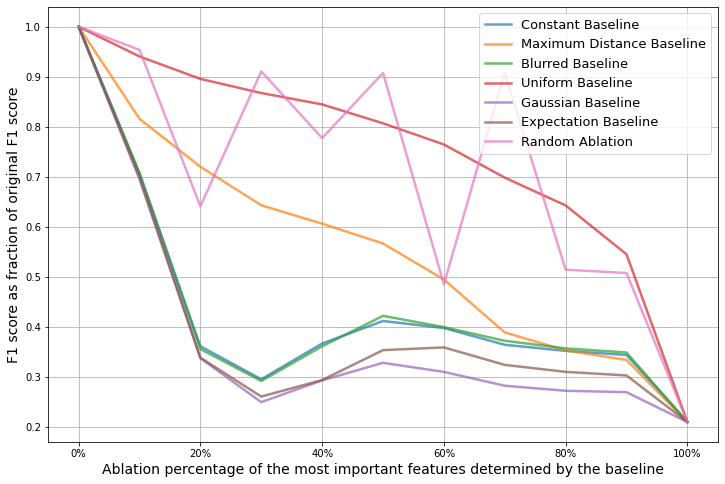

Start iteration for dataset 'communities'
Try to load the model..
Accuracy test: 0.8721804511278195
F1-Score test: 0.7329842931937172
Loading all baselines..
Get correct predictions..
X_test of correct predictions shape: (348, 100)
Y_test of correct predictions shape: (348,)
Label in Y_test of correct predictions ratio: 
 [[  0 278]
 [  1  70]]
Get all attr. scores for the different baselines..
Start kernel_shap for correct predictions with black_baseline



--- '17.92' seconds computation time ---
Start kernel_shap for correct predictions with max_dist_baseline
--- '18.76' seconds computation time ---
Start kernel_shap for correct predictions with blurred_baseline



--- '263.98' seconds computation time ---
Start kernel_shap for correct predictions with uniform_baseline



--- '264.66' seconds computation time ---
Start kernel_shap for correct predictions with gaussian_baseline



--- '264.29' seconds computation time ---
Start kernel_shap for correct predictions with train_baseline



--- '263.31' seconds computation time ---


AttributeError: 'DataFrame' object has no attribute 'load_imputation'

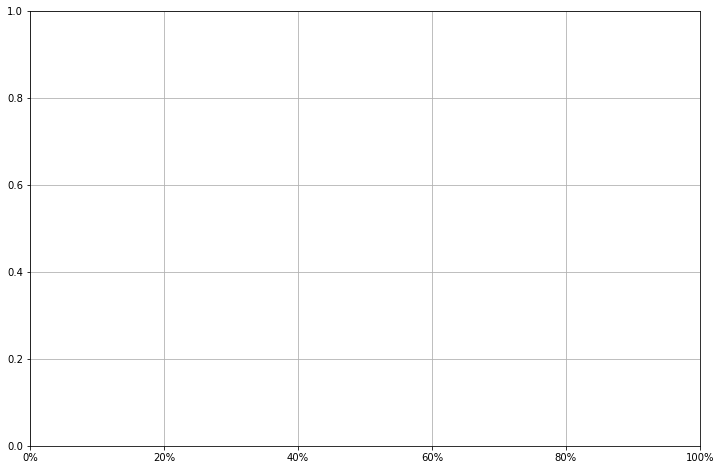

In [17]:
errors_dict = defaultdict(list)
datasets_names = ['compas', 'communities', 'fraud_detection', 'spambase']
datasets_paths = ['compas/', 'crime/', 'fraud_detection/', 'spambase/']
method = 'KernelSHAP'
model_name = 'svm'

for dataset_name, dataset_path in zip(datasets_names, datasets_paths):
    np.random.seed(rs)
    random.seed(rs)
    
    fig = plt.figure(figsize=(12,8))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.grid()
        
    print(f"Start iteration for dataset '{dataset_name}'")
    
    data = f'datasets/{dataset_path}' if dataset_name == 'har' else pd.read_csv('datasets/' + dataset_path + dataset_name + '.' + 'csv')
    
    X_train, X_test, Y_train, Y_test = dataloader.prepare_dataset(dataset_name, data)
        
    print("Try to load the model..")
    model = svm_model.train(X_train, Y_train, X_test, Y_test)
    
    print("Loading all baselines..")
    bun = BaselineUtilNumpy(N)
    
    black_baseline = bun.create_black_baseline(X_train)
    blurred_baseline = bun.create_blurred_baseline(X_train, 10)
    uniform_baseline = bun.create_uniform_baseline(X_train)
    gaussian_baseline = bun.create_gaussian_baseline(X_train, 0.5)
    train_baseline = bun.create_train_baseline(X_train)
    
    print("Get correct predictions..")
    X_test_c, Y_test_c = get_correct_predictions(model, X_test, Y_test)
        
    #ks for the top k ablation test
    ks = np.arange(start=0.0, stop=1.1, step=0.1)
    
    print("Get all attr. scores for the different baselines..")
    bb_shap_values_c, mdb_shap_values_c, blb_shap_values_c, ub_shap_values_c, gb_shap_values_c, tb_shap_values_c = calc_shap_values(X_test_c, black_baseline, 
                                                                                                                                    blurred_baseline, uniform_baseline, 
                                                                                                                                    gaussian_baseline, train_baseline, model)    
    shap_values_c = {
          "Constant Baseline": bb_shap_values_c,
          "Maximum Distance Baseline": mdb_shap_values_c,
          "Blurred Baseline": blb_shap_values_c,
          "Uniform Baseline": ub_shap_values_c,
          "Gaussian Baseline": gb_shap_values_c,
          "Expectation Baseline": tb_shap_values_c
    }
    
    #Top k ablation
    imputation = imputation.load_imputation(imputation_typ, X_test_c)
    test_errors = []
    for name, sv in shap_values_c.items():
        for k in ks:
            key = name + str(round(k,1))
            error = top_k_ablation_row_wise(model, X_test_c.copy(deep=True), Y_test_c, sv, k, imputation)
            test_errors.append(error)
            errors_dict[key].append(error)
            
        plt.plot(ks, test_errors, label=name, linewidth=2.5, alpha=0.7)
        test_errors.clear()
        
    for k in ks:
        key = 'Random Ablation' + str(round(k,1))
        error = random_k_ablation_row_wise(model, X_test_c.copy(deep=True), Y_test_c, k, imputation)
        test_errors.append(error)
        errors_dict[key].append(error)
        
    plt.plot(ks, test_errors, label='Random Ablation', linewidth=2.5, alpha=0.7)
    test_errors.clear()
        
    plt.xlabel('Ablation percentage of the most important features determined by the baseline',fontsize=14)
    plt.ylabel('F1 score as fraction of original F1 score', fontsize=14)
    plt.legend(prop={'size': 13})
    fig.savefig(f"plots/top_k_test_{method}_{dataset_name}_{model_name}.pdf", dpi=fig.dpi,
                format='pdf', bbox_inches='tight')
    plt.show()
       

# Create overall AVG plots

In [ ]:
baseline_names = ["Constant Baseline",
"Maximum Distance Baseline",
"Blurred Baseline",
"Uniform Baseline",
"Gaussian Baseline",
"Expectation Baseline",
"Random Ablation"]

test_errors = defaultdict(list)
test_std = defaultdict(list)

for b in baseline_names:
    for k in ks:
        key = b + str(round(k,1))
        test_errors[b].append(np.mean(errors_dict[key]))
        test_std[b].append(np.std(errors_dict[key]))

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.grid()

for b in baseline_names:
    y = np.asarray(test_errors[b])
    std = np.asarray(test_std[b])
    plt.plot(ks, y, label=b, linewidth=2.5, alpha=0.7)
    plt.fill_between(ks, y-(std/2), y+(std/2), alpha = 0.2)

plt.xlabel('Ablation percentage of the most important features determined by the baseline',fontsize=14)
plt.ylabel('F1 score as fraction of original F1 score', fontsize=14)
plt.legend(prop={'size': 13})
fig.savefig(f"plots/top_k_test_AVG_{method}_w_shader.pdf", dpi=fig.dpi,
            format='pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.grid()

for b in baseline_names:
    y = np.asarray(test_errors[b])
    std = np.asarray(test_std[b])
    plt.plot(ks, y, label=b, linewidth=2.5, alpha=0.7)

plt.xlabel('Ablation percentage of the most important features determined by the baseline',fontsize=14)
plt.ylabel('F1 score as fraction of original F1 score', fontsize=14)
plt.legend(prop={'size': 13})
fig.savefig(f"plots/top_k_test_AVG_{method}.pdf", dpi=fig.dpi,
            format='pdf', bbox_inches='tight')